# 2b. Make predictions using patient-level snapshots

Now that the data have been prepared in snapshot form, we have a dataset of unfinished visits. The ultimate goal is to make predictions about whether an outcome of interest (e.g. admission, discharge) will happen within a prediction window. For now, I will use a simple outcome variable of admission or not, without worrying about when that admission happened. 

Everything shown here is standard modelling, but there are some important considerations when working with unfinished hospital visits.

## Things to consider when training predictive models using snapshots

**Random versus temporal splits**

When dividing your data into training, validation and test sets, a random allocation can give an optimistic assessment of prospective model performance, as the model’s robustness to any temporal changes in patient characteristics, flow-outcomes or the relationships between these goes untested. A more robust approach for testing models intended for prospective use is to apply temporal splits, where you train on earlier data and validate/test on later data, mimicking how the model would be deployed in a real-world setting. I show the application of temporal splits here.

**Multiple snapshots per visit**

To use `patientflow` your data should be in snapshot form. I showed how to create this in the last notebook. I defined a series of prediction times, and then sampled finished visits to get snapshots that represent those visits while still in progress. When you follow this method, you may end up with multiple snapshots per patient visit. Is this OK, for your analysis? You will need to decide whether you include all snapshots from a single visit into the training, validation or testing of a predictive model. Snapshots from the same visit are inherently correlated, which may violate assumptions of the statistical or machine learning methods you are using. For this reason, we chose to sample only one snapshot per patient visit. 

**Multiple visits per patient**

The patient identifier is also important, because if the same patient appears in training and test sets, there is the potential for data leakage. We took the decision to probabilistically allocate each patient to training, validation or test set, where the probability of being allocated to each set is in proportion to the number of visits they made in any of those time periods. 

`patientflow` includes functions to handle all of these considerations. I demonstrate them here.


In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

## Create fake snapshots

See the previous notebook for more information about how this is done. 

In [2]:
from patientflow.generate import create_fake_snapshots
prediction_times = [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)] 
snapshots_df=create_fake_snapshots(prediction_times=prediction_times, start_date='2023-01-01', end_date='2023-04-01')
snapshots_df.head()

,snapshot_date,prediction_time,patient_id,visit_number,is_admitted,age,latest_triage_score,num_urinalysis_orders,num_troponin_orders,num_bmp_orders,num_cbc_orders,num_d-dimer_orders
snapshot_id,,,,,,,,,,,,
0,2023-01-01,"(6, 0)",1958,26,0,37,5.0,1,1,0,0,0
1,2023-01-01,"(9, 30)",1958,26,0,37,5.0,1,1,0,0,0
2,2023-01-01,"(9, 30)",2782,36,1,28,3.0,0,1,1,1,0
3,2023-01-01,"(9, 30)",504,42,0,43,4.0,0,1,0,0,0
4,2023-01-01,"(9, 30)",2405,29,0,28,4.0,0,0,0,0,0


## Train a model to predict the outcome of each snapshot

We decided in our work at UCLH to train a different model for each prediction time in the day. That was a design-led decision; we wanted each model to be able to pick up different signals of the outcome at different times of day. You'll see the results of this in later notebooks where I show shap plots for models at different times of day. 

For now, let's train a model to predict admission for the 9:30 prediction time. 

I will specify that the triage scores are ordinal, to make use of sklearn's OrdinalEncoder to maintain the natural order of categories. 

I exclude columns that are not relevant to the prediction of probability of admission, including `snapshot_date` and `prediction_time`.

### Create temporal splits

The `create_temporal_splits()` function below will randomly allocate each patient_id to training, validation and test sets, where the probability of being allocated to each is in proportion to the number of visits they made in any of those time periods. 


In [3]:
from datetime import date   
from patientflow.prepare import create_temporal_splits

# set the temporal split
start_training_set = date(2023, 1, 1) 
start_validation_set = date(2023, 2, 15) # 6 week training set 
start_test_set = date(2023, 3, 1) # 2 week validation set 
end_test_set = date(2023, 4, 1) # 1 month test set

# create the temporal splits
train_visits, valid_visits, test_visits = create_temporal_splits(
    snapshots_df,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date", # states which column contains the date to use when making the splits 
    patient_id="patient_id", # states which column contains the patient id to use when making the splits 
    visit_col="visit_number", # states which column contains the visit number to use when making the splits 

)


Patient Set Overlaps (before random assignment):
Train-Valid: 0 of 2636
Valid-Test: 56 of 1851
Train-Test: 156 of 3061
All Sets: 0 of 3668 total patients
Split sizes: [3179, 1025, 2157]


The function above returned information on the final size of each split, and on how many patients were found in more than one set. In this case, 29 patients were found in the validation and test set periods. Each of these patients has been probabilistically allocated to just one set. 

### Select one snapshot per visit

You will need to decide whether you include all snapshots from a single visit into a predictive model.

Since we train a different model for each prediction time, then any visits spanning more than 24 hours will have multiple rows. If your snapshots are drawn from visits to ED, this should hopefully not happen too often. If your snapshots are drawn from inpatient visits, then it is very likely that you will have multiple rows per patient. 

We took the decision to select one snapshot per visit at random. The function below gives you this option. If you specify `single_snapshot_per_visit` as True, the `train_classifier` function will expect a `visit_col` parameter. 

## Train a classifier to predict probability of admission

Below I'm using `train_classifier()`, which is a wrapper on standard scikit-learn functions. There are a few parameters in this function to explain. 

- `grid`: specifies the grid to use in hyperparameter tuning.
- `prediction_time`: is used to identify which patient snapshots to use for training.
- `single_snapshot_per_visit`: if this is True, the function will randomly pick one snapshot for any visit, using `visit_col` as the column name that identifies the visit identifier. 
- `exclude_from_training_data`: certain columns in the data should not be used for training, including visit numbers and dates.
- `ordinal_mappings`: the function makes use of SKLearn's Ordinal Mapping encoder.
- `use_balanced_training`: in healthcare contexts, there are often fewer observations in the positive class. Set this to True for imbalanced samples (common for ED visits, when most patients are discharged, and for predicting inpatient discharge from hospital when most patients remain). It will downsample the negative class. 
- `calibrate_probabilities`: when you downsample the negative class, it is a good idea to calibrate the probabilities to account for this class imbalance. Setting this to True will use a sigmoid function to calibrate the predicted probabilities, ensuring they better reflect the probabilities in the original data distribution.
- `calibration_method`: options are sigmoid or isotonic; I have found that sigmoid (the default) works better.
- `evaluate_on_test`: by default, this is set to False so the function will only return performance metrics for the test set; it is good practice to evaluate on the test set only when happy with validation set performance

By default, the function will use an XGBoost classifier, initialised with the hyperparameter grid provided, with log loss as the evaluation metric. Chronological cross-validation is used, with the best hyperparameters selected based on minimising log loss in the validation set. We chose XGBoost because it is quick to train, generally performs well, and handles missing values. 

If you wish to use a different classifier, you can use another argument:

- `model_class` (not shown here):  You can pass your own model in an optional model_class argument, which expects classifier class (like XGBClassifier or other scikit-learn compatible classifiers) that can be instantiated and initialised by providing further parameters.

In [5]:
from patientflow.train.classifiers import train_classifier

# exclude columns that are not needed for training
exclude_from_training_data=['patient_id', 'visit_number', 'snapshot_date', 'prediction_time']

# train the patient-level model
model = train_classifier(
    train_visits=train_visits,
    valid_visits=valid_visits,
    grid={"n_estimators": [20, 30, 40]},
    prediction_time=(9, 30),
    exclude_from_training_data=exclude_from_training_data,
    ordinal_mappings={'latest_triage_score': [1, 2, 3, 4, 5]},
    single_snapshot_per_visit=True,
    visit_col='visit_number', # as we are using a single snapshot per visit, we need to specify which column contains the visit number
    use_balanced_training=True,
    calibrate_probabilities=True,
    calibration_method='sigmoid',
    evaluate_on_test=False, # by default, this is set to False; only evaluate on the test set when happy with validation set performance
)


## Inspecting the object returned by `train_classifier()`

The function returns an object of type TrainedClassifer(). Meta data and metrics from the training process are returned with it. 

In [6]:
print(f'Object returned is of type: {type(model)}')

print(f'\nThe metadata from the training process are returned in the `training_results` attribute:')
model.training_results

Object returned is of type: <class 'patientflow.model_artifacts.TrainedClassifier'>

The metadata from the training process are returned in the `training_results` attribute:


TrainingResults(prediction_time=(9, 30), training_info={'cv_trials': [HyperParameterTrial(parameters={'n_estimators': 20}, cv_results={'train_auc': np.float64(0.9863488774220018), 'train_logloss': np.float64(0.2345235821107298), 'train_auprc': np.float64(0.9839960012755344), 'valid_auc': np.float64(0.7404647983595354), 'valid_logloss': np.float64(0.6777401688701863), 'valid_auprc': np.float64(0.732305765806727)}), HyperParameterTrial(parameters={'n_estimators': 30}, cv_results={'train_auc': np.float64(0.9934036840041577), 'train_logloss': np.float64(0.19339304359858095), 'train_auprc': np.float64(0.992275317414658), 'valid_auc': np.float64(0.7414445203918889), 'valid_logloss': np.float64(0.7224622072494462), 'valid_auprc': np.float64(0.739694204530856)}), HyperParameterTrial(parameters={'n_estimators': 40}, cv_results={'train_auc': np.float64(0.9966901551317282), 'train_logloss': np.float64(0.16839291934975475), 'train_auprc': np.float64(0.9957460357414476), 'valid_auc': np.float64(0.7

To get a better view of what is included within the results, here is a list of the fields returned: 

In [7]:
from dataclasses import fields
print("\nDataclass fields in TrainingResults:")
for field in fields(model.training_results):
    print(field.name)


Dataclass fields in TrainingResults:
prediction_time
training_info
calibration_info
test_results
balance_info


The prediction time has been saved with the model. When the model's predict method is used, the method will that the requested prediction time and that of the model align. 

In [9]:
print(f'The prediction time is: {model.training_results.prediction_time}')

The prediction time is: (9, 30)


An object called training_info contains information related to model training. To simplify the code below, I'll assign it to a variable called results. It will tell us the size and class balance of each set 


In [11]:
results = model.training_results.training_info

print(f"The training_info object contains the following keys: {results.keys()}")

print(f"\nNumber in each set{results['dataset_info']['train_valid_test_set_no']}")

def print_class_balance(d):
    for k in d:
        if d[k] is not None:
            print(f"{k.split('_')[1]}: {d[k][0]:.1%} neg, {d[k][1]:.1%} pos")
        else:
            print(f"{k.split('_')[1]}: None")


print_class_balance(results['dataset_info']['train_valid_test_class_balance'])

The training_info object contains the following keys: dict_keys(['cv_trials', 'features', 'dataset_info'])

Number in each set{'train_set_no': 412, 'valid_set_no': 141, 'test_set_no': None}
train: 70.1% neg, 29.9% pos
valid: 70.2% neg, 29.8% pos
test: None


Class balance information is also saved in the training_results, which will store information about the differences between the class balance when forcing the training set to be balanced

In [12]:
model.training_results.balance_info

{'is_balanced': True,
 'original_size': 412,
 'balanced_size': 246,
 'original_positive_rate': np.float64(0.29854368932038833),
 'balanced_positive_rate': np.float64(0.5),
 'majority_to_minority_ratio': 1.0}

And the type of calibration done on balanced samples is saved in training_results also

In [17]:
model.training_results.calibration_info

{'method': 'sigmoid'}

Results of hyperparameter tuning are saved in a HyperParameterTrial object

In [18]:
# results are stored in a HyperParameterTrial object
results['cv_trials']

[HyperParameterTrial(parameters={'n_estimators': 20}, cv_results={'train_auc': np.float64(0.9863488774220018), 'train_logloss': np.float64(0.2345235821107298), 'train_auprc': np.float64(0.9839960012755344), 'valid_auc': np.float64(0.7404647983595354), 'valid_logloss': np.float64(0.6777401688701863), 'valid_auprc': np.float64(0.732305765806727)}),
 HyperParameterTrial(parameters={'n_estimators': 30}, cv_results={'train_auc': np.float64(0.9934036840041577), 'train_logloss': np.float64(0.19339304359858095), 'train_auprc': np.float64(0.992275317414658), 'valid_auc': np.float64(0.7414445203918889), 'valid_logloss': np.float64(0.7224622072494462), 'valid_auprc': np.float64(0.739694204530856)}),
 HyperParameterTrial(parameters={'n_estimators': 40}, cv_results={'train_auc': np.float64(0.9966901551317282), 'train_logloss': np.float64(0.16839291934975475), 'train_auprc': np.float64(0.9957460357414476), 'valid_auc': np.float64(0.7385623148781044), 'valid_logloss': np.float64(0.7471921775214785), 

In [19]:

# Find the trial with the lowest validation logloss
best_trial = min(results["cv_trials"], key=lambda trial: trial.cv_results['valid_logloss'])

# print the best parameters
print(f'The best parameters are: {best_trial.parameters}')

The best parameters are: {'n_estimators': 20}


Note that, by default, no test set results are returned by train_classifier. To see AUROC, log loss and AUPRC on the test set, change `evaluate_on_test` parameter to True above. 

In [20]:
print(f'The results on the test set were:')
model.training_results.test_results


The results on the test set were:


Note that each record in the snapshots dataframe is indexed by a unique snapshot_id. 

## Evaluating training results

The following function enables you to plot the results of hyperparameter trials, which have been saved with the trained model. The input to the plot is a list of `HyperParameterTrial` instances containing validation set results and hyperparameter settings. Each trial's `cv_results` dictionary contains 'valid_auc' and 'valid_logloss' metrics, which have been computed for each hyperparameter configuration using the validation set.

As I only including one hyperparameter in my grid, and the data is made up, the plots are not that informative. With real data and a full hyperparameter grid, figures like these can help you can iterate towards an optimal set of hyperparameters. 

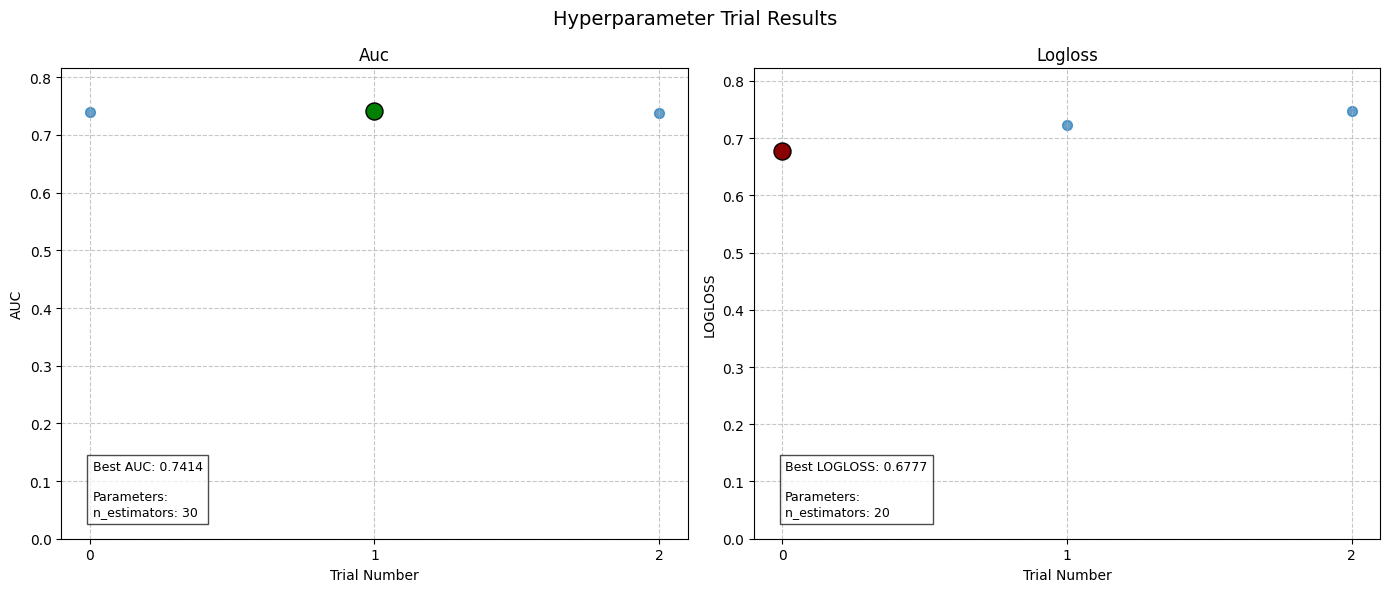

In [28]:
from patientflow.viz.trial_results import plot_trial_results  

plot_trial_results(trials_list = model.training_results.training_info['cv_trials'])

## Summary

Here I have shown how `patientflow` can help you

* handle multiple snapshots per visit and multiple visits per patient
* impose a temporal split on your training and test sets, allowing for the point above 
* train a model to predict some later outcome using functions that handle class imbalance and calibration
* access various attributes of the model, that are saved as part of the model object
* plot the results of hyperparameter tuning

In the next notebook, I show how to evaluate models applied to patient snapshots. It is good practice to use your validation set results for the evaluations shown in this notebook and the next one, and to use the test set for evaluation only once you are satisified with your model.